# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки:

In [1]:
pip install sweetviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
import seaborn as sns
import numpy as np
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import sweetviz as sv
%matplotlib inline

Загрузим данные и создадим список ключей:

In [3]:
reg_1 = pd.read_csv('/datasets/geo_data_0.csv')
reg_2 = pd.read_csv('/datasets/geo_data_1.csv')
reg_3 = pd.read_csv('/datasets/geo_data_2.csv')

region_list = {'Region 1': reg_1,
               'Region 2': reg_2,
               'Region 3': reg_3,}

Изучим данные:

In [4]:
for reg in region_list:
    region_list[reg].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

Пропусков нет, рассмотри EDA библиотеки sweetviz:

In [5]:
report_reg_1 = sv.analyze([reg_1, "Region 1"])
report_reg_2 = sv.analyze([reg_2, "Region 2"])
report_reg_3 = sv.analyze([reg_3, "Region 3"])

                                             |          | [  0%]   00:00 -> (? left)

                                             |          | [  0%]   00:00 -> (? left)

                                             |          | [  0%]   00:00 -> (? left)


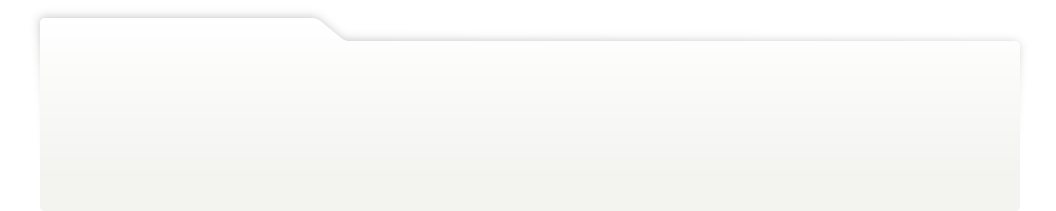
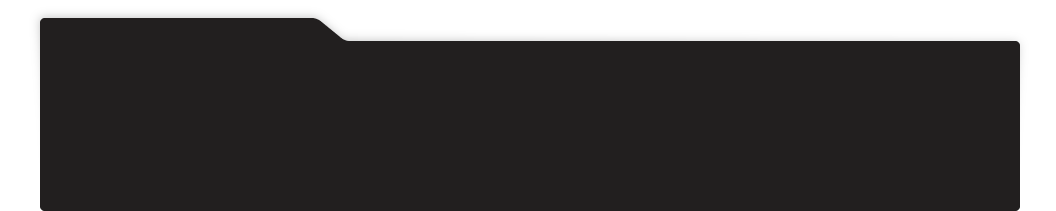
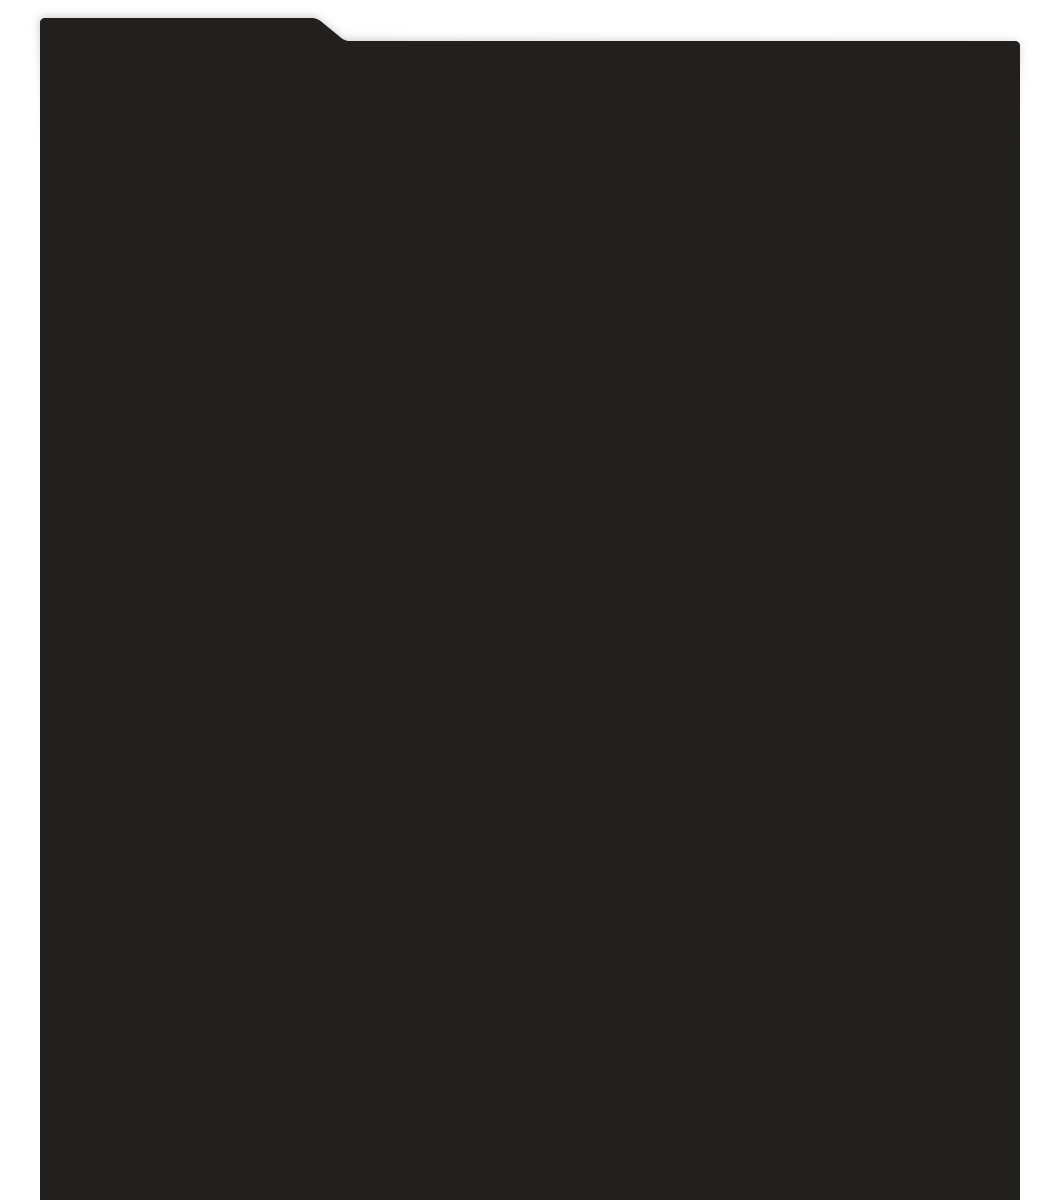
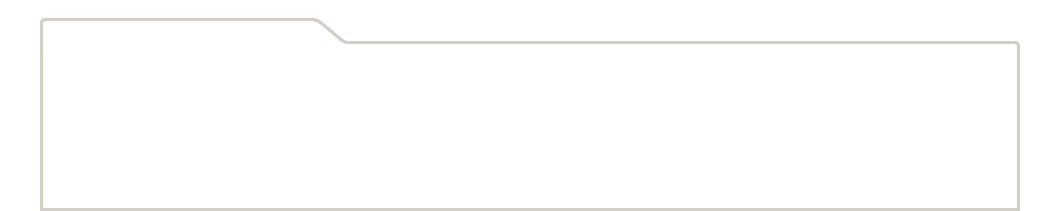
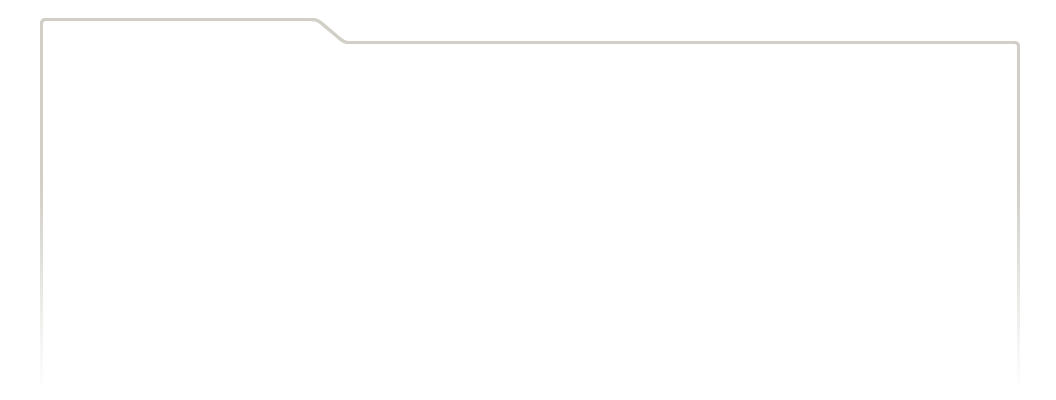
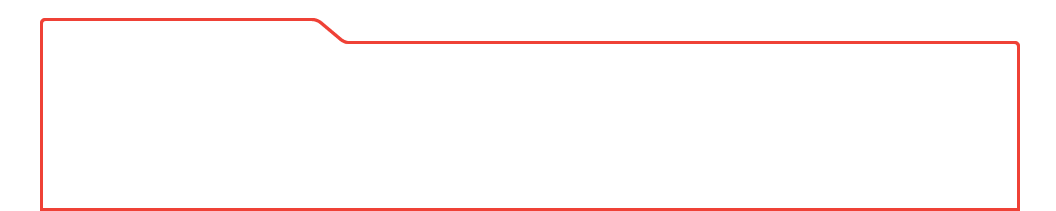
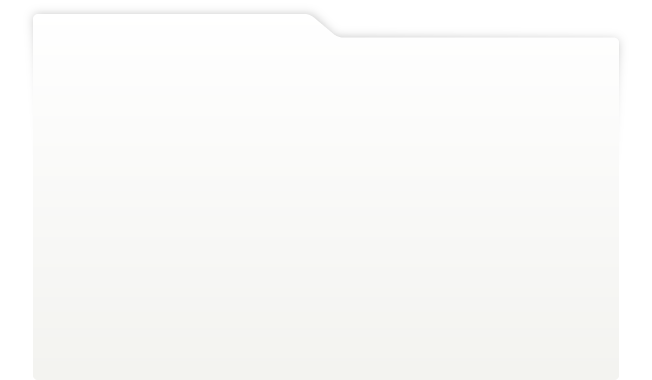
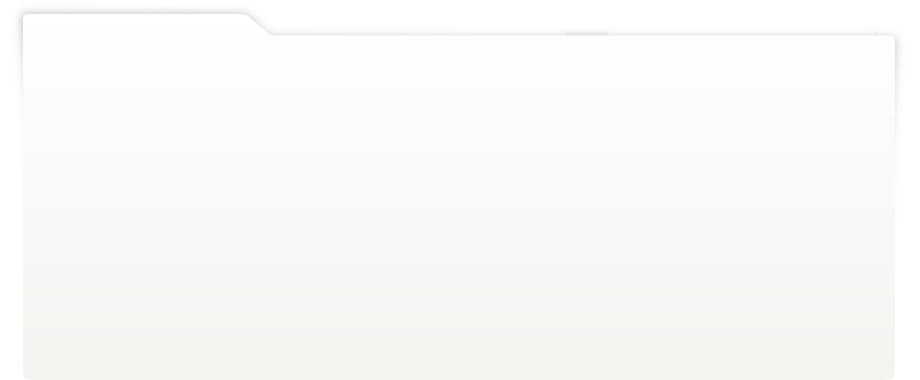
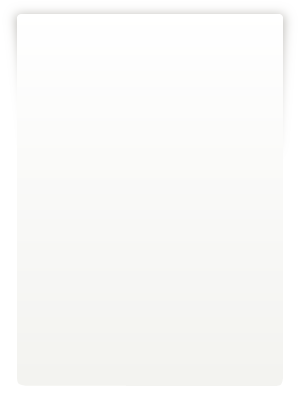
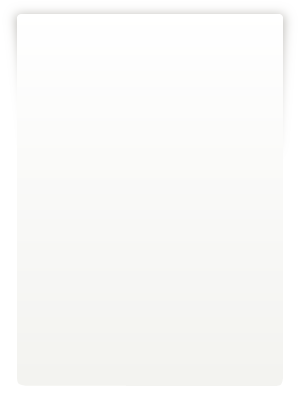
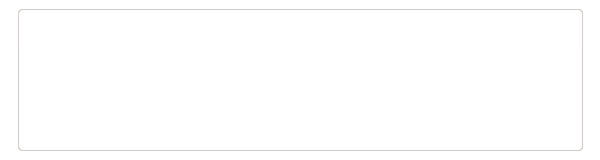
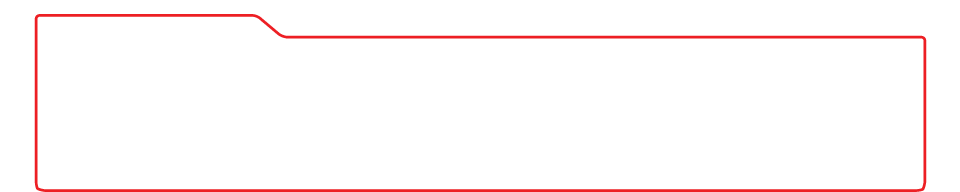
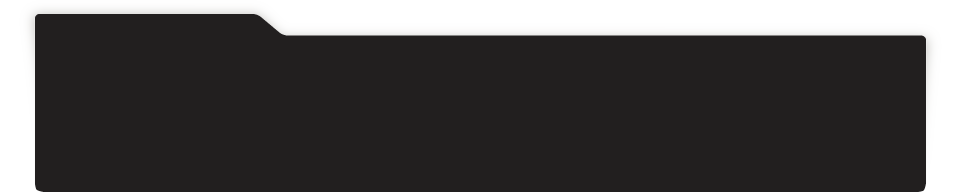
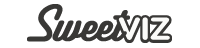
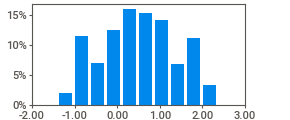
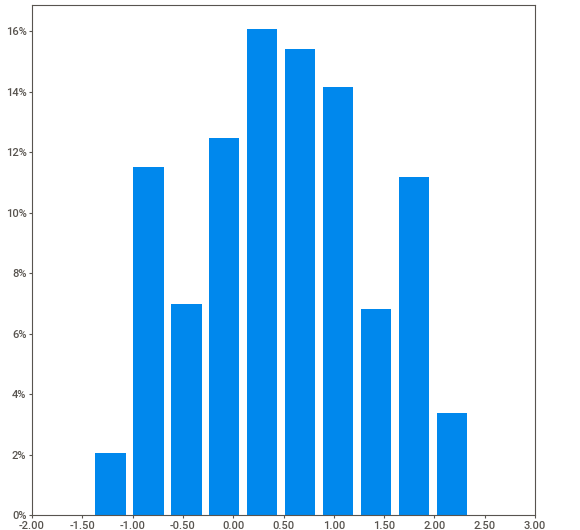
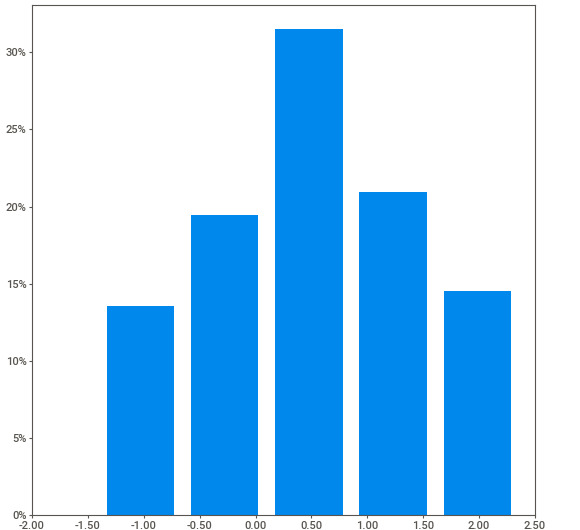
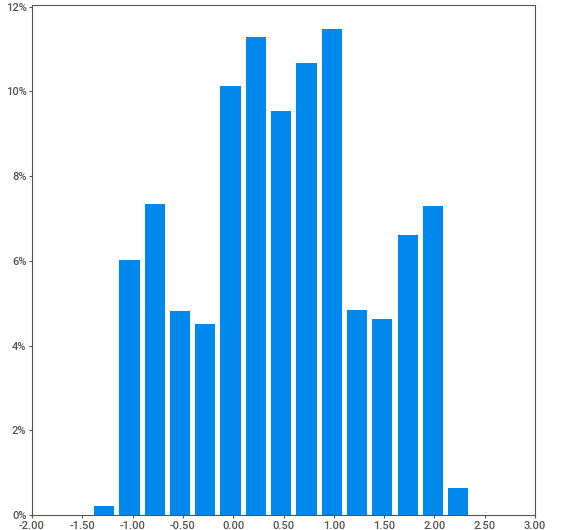
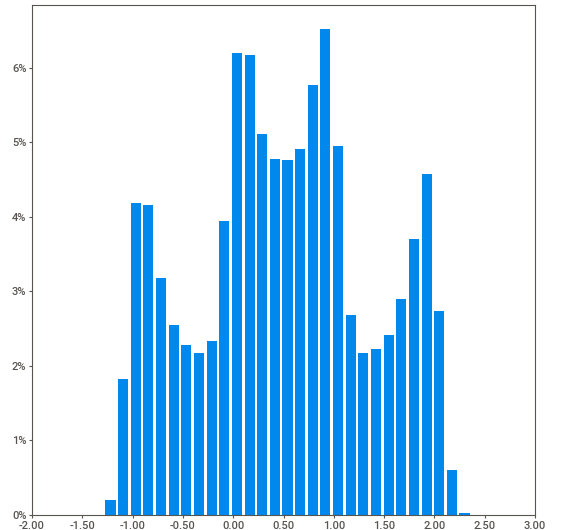
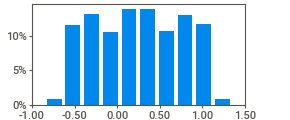
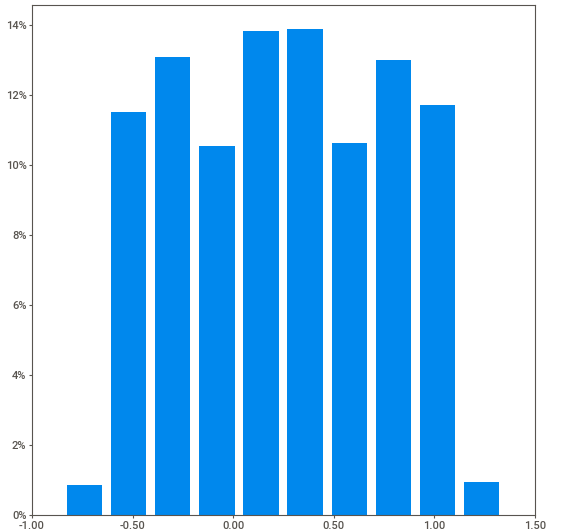
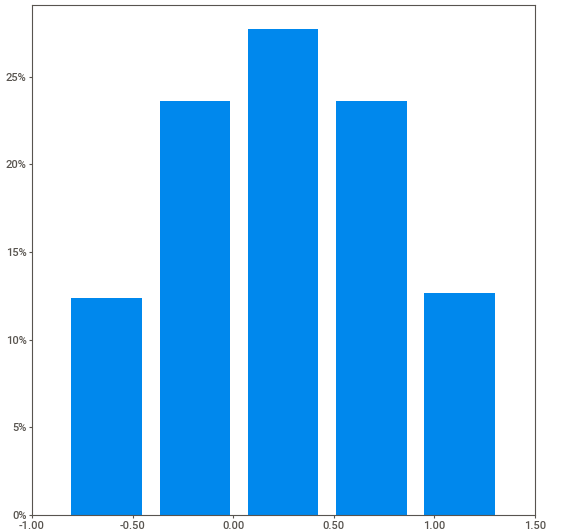
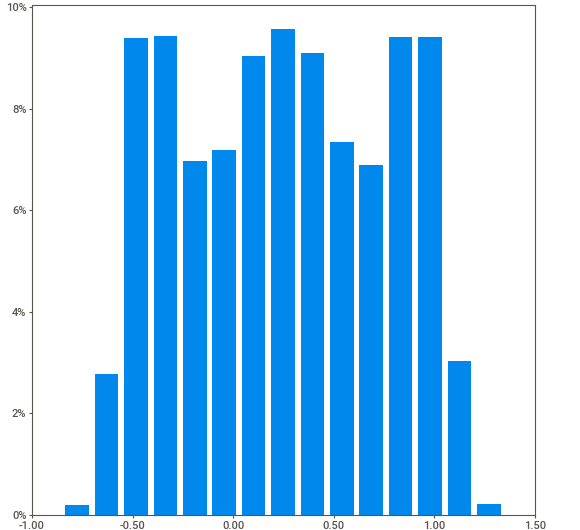
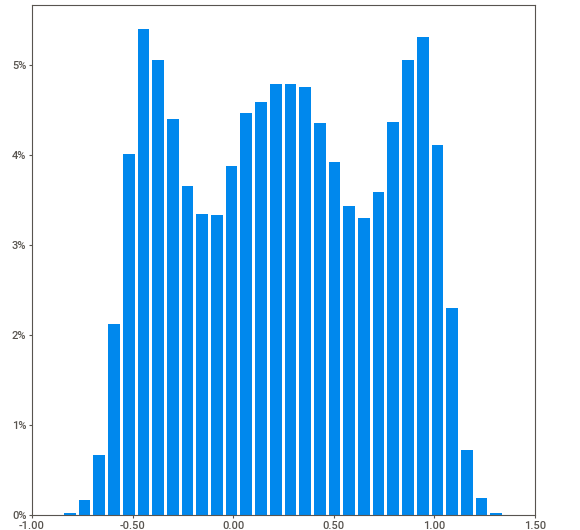
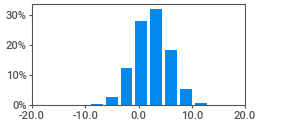
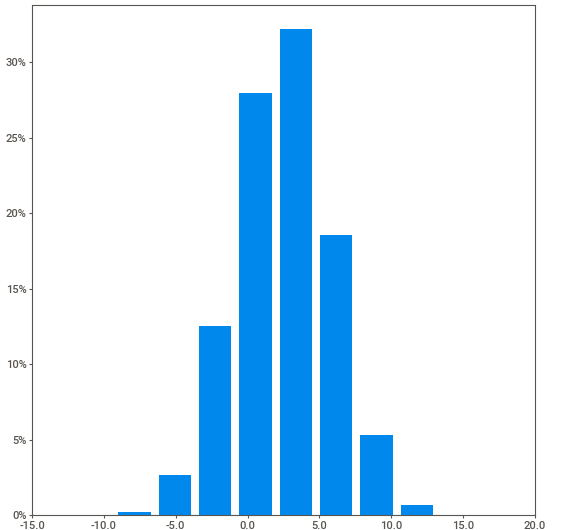
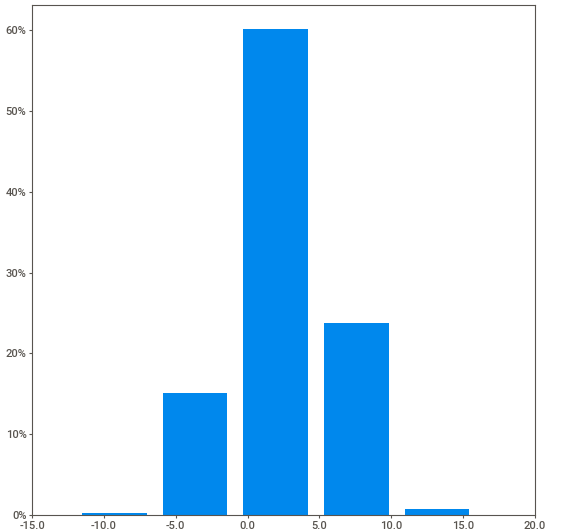
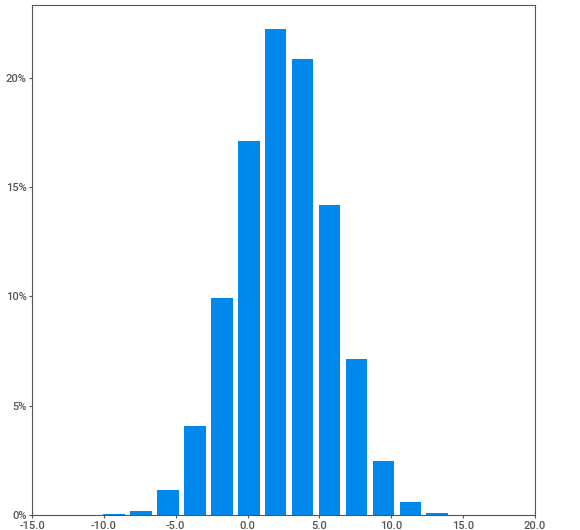
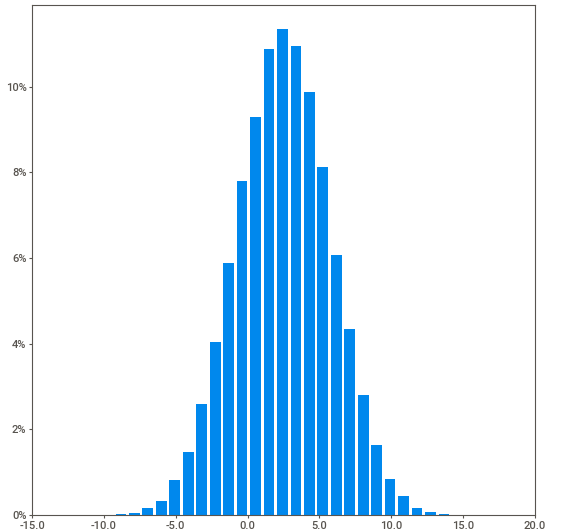
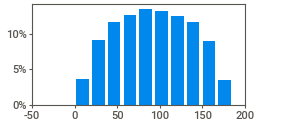
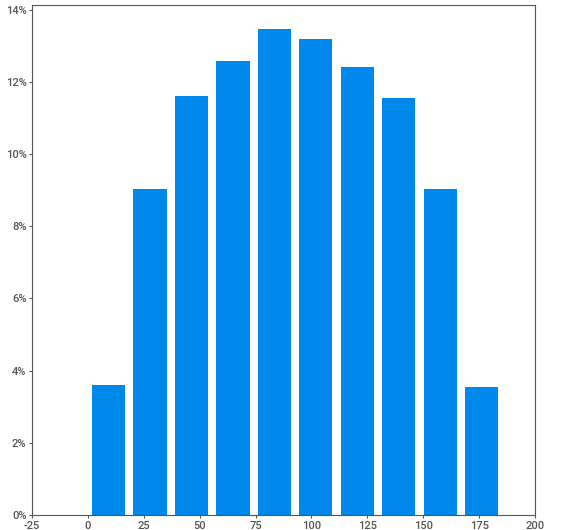
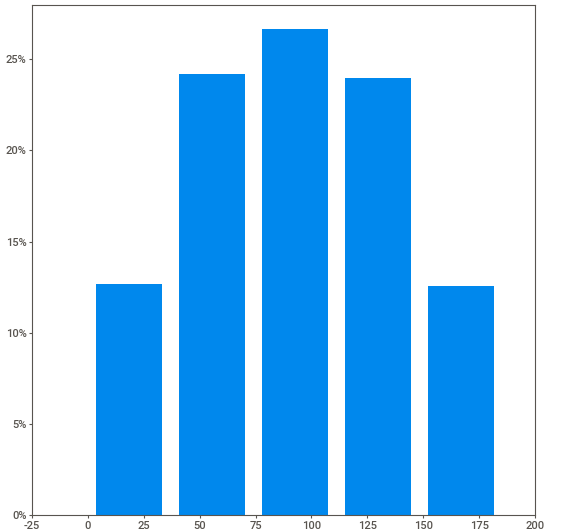
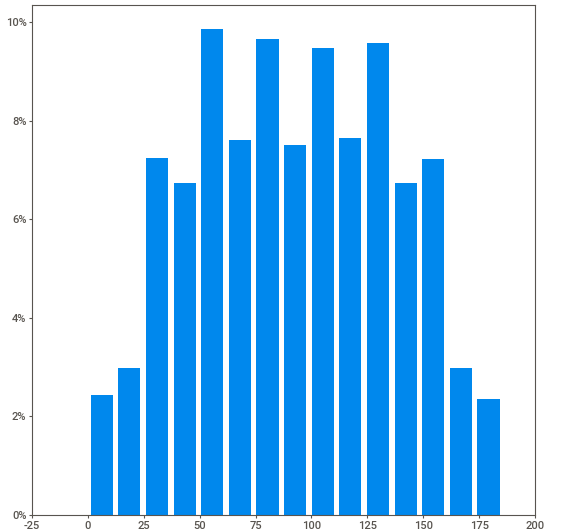
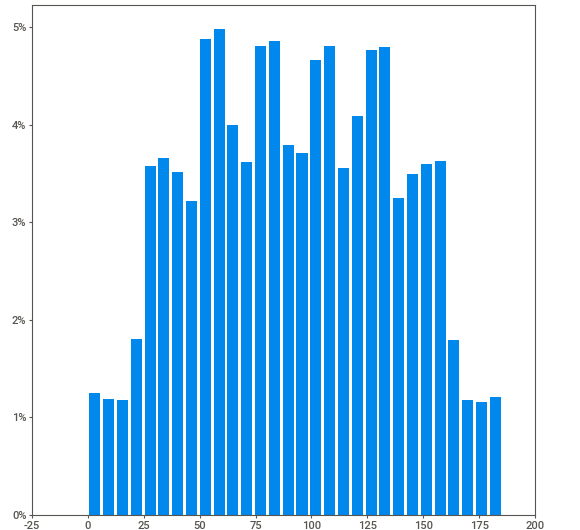
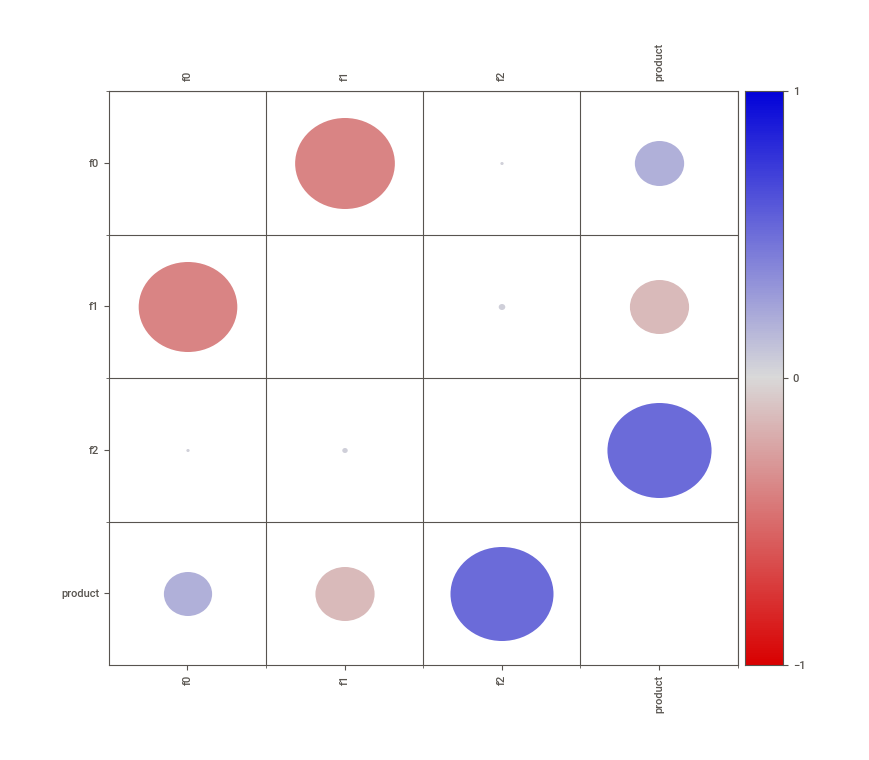
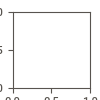

In [6]:
report_reg_1.show_notebook(w='100%', h='full', scale=0.9)


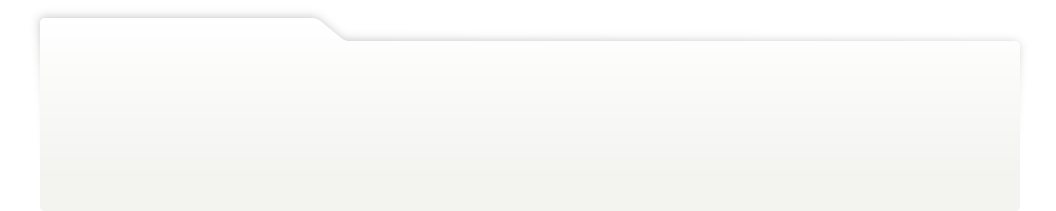
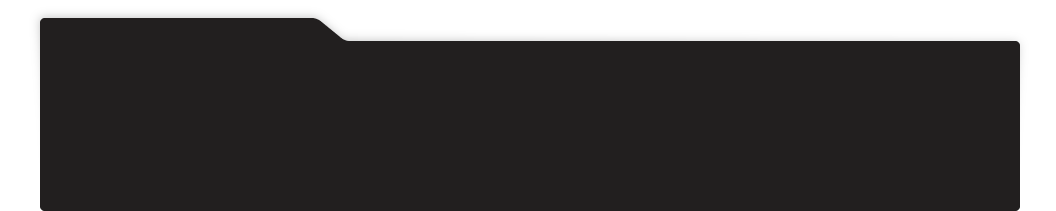
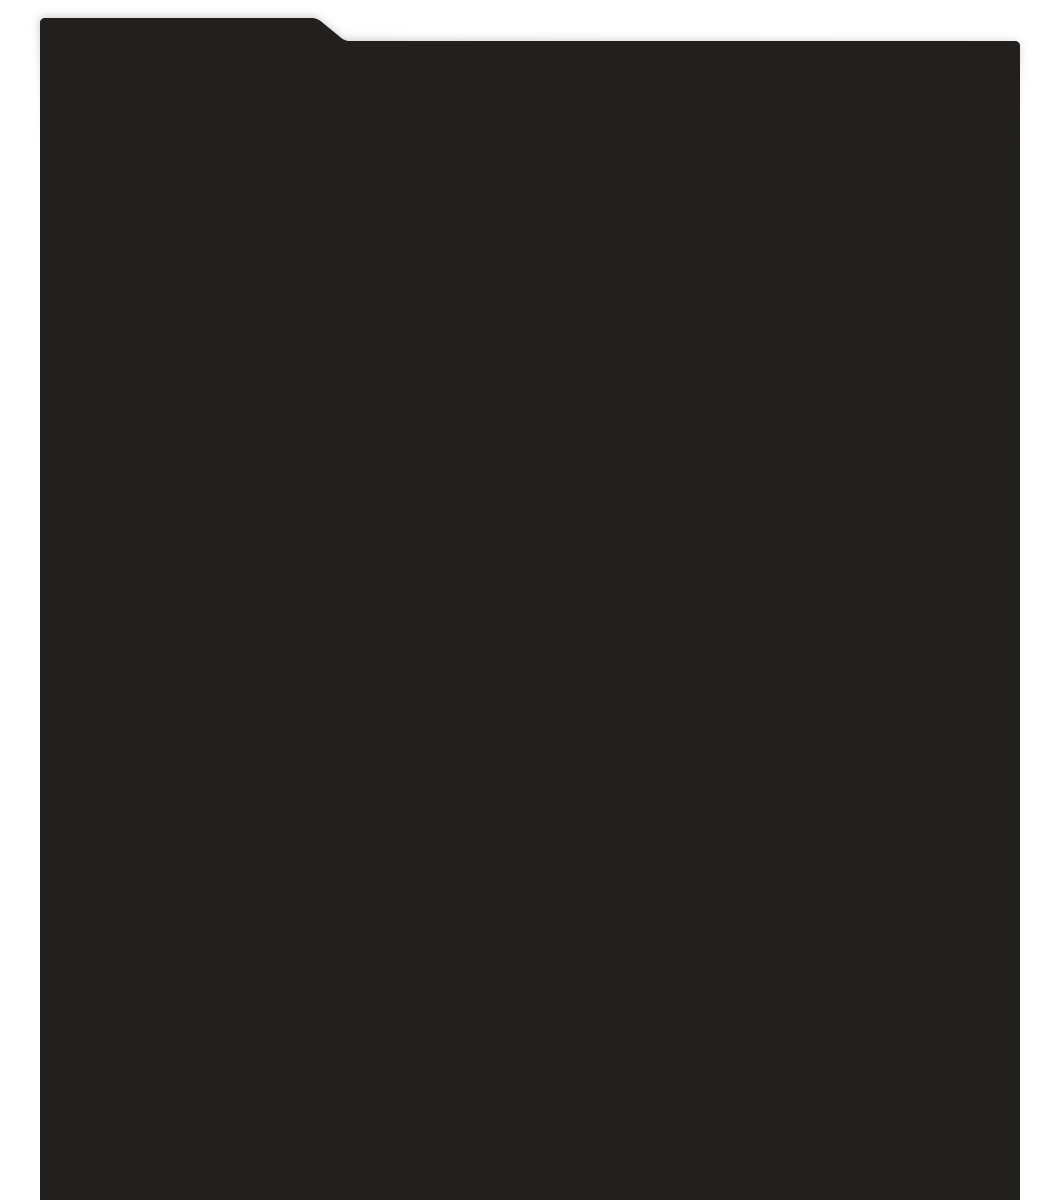
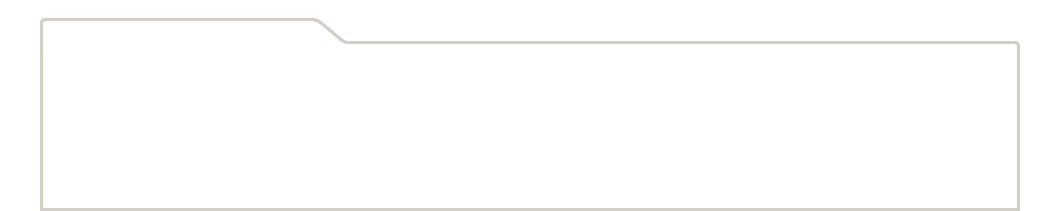
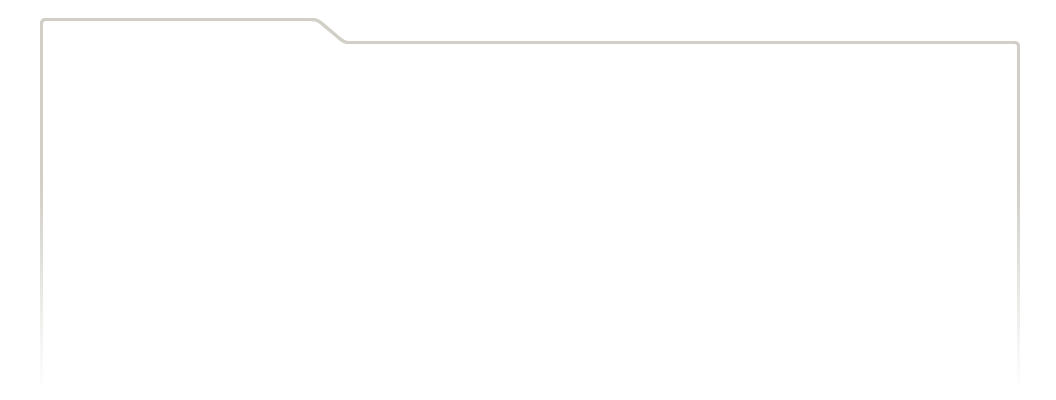
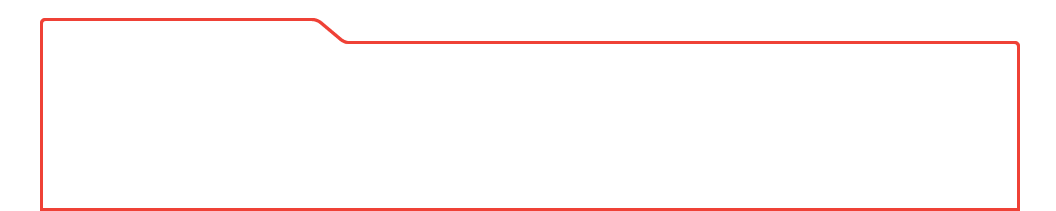
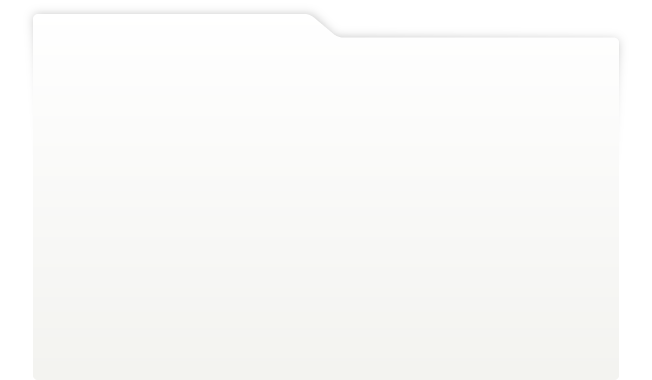
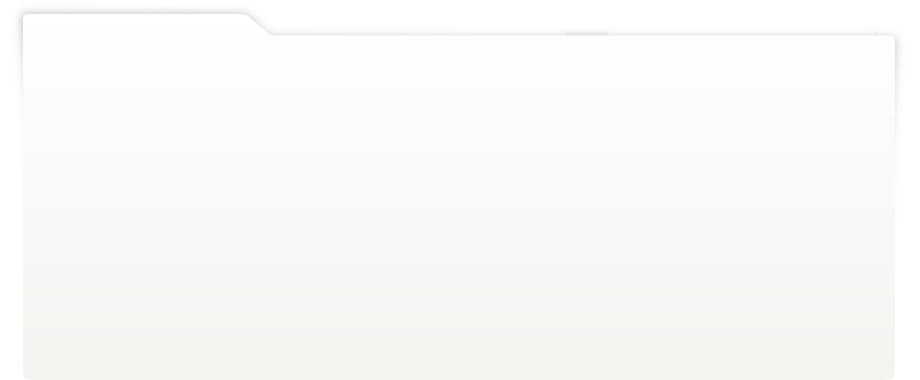
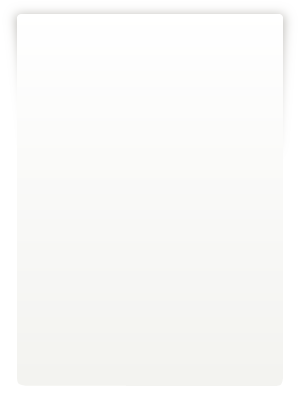
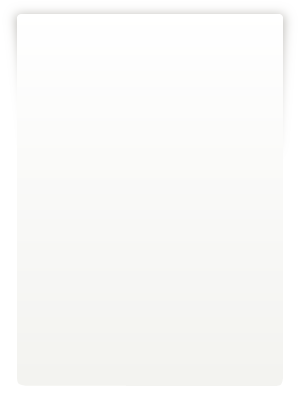
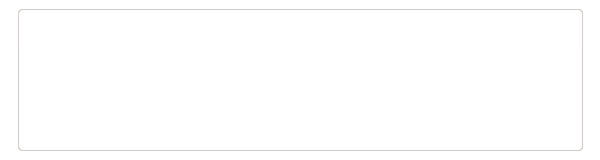
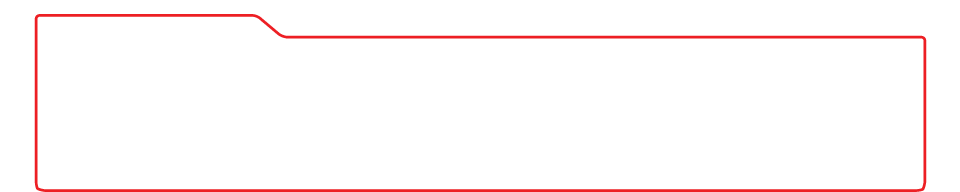
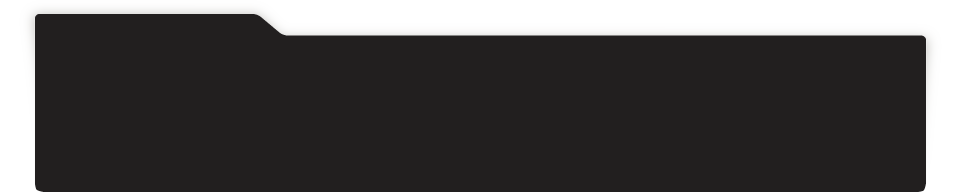
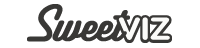
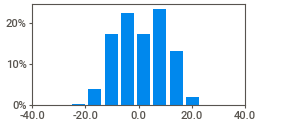
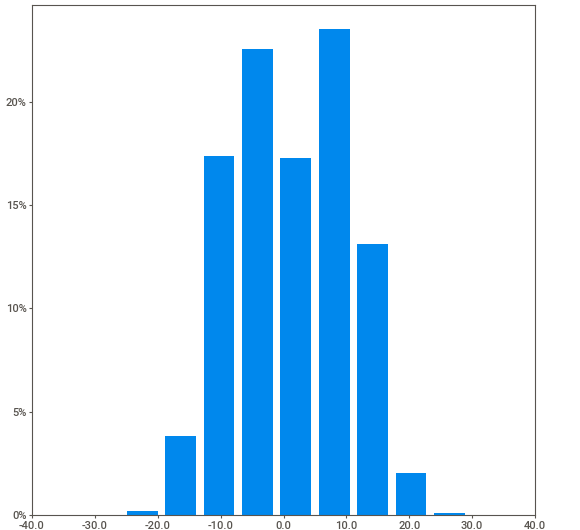
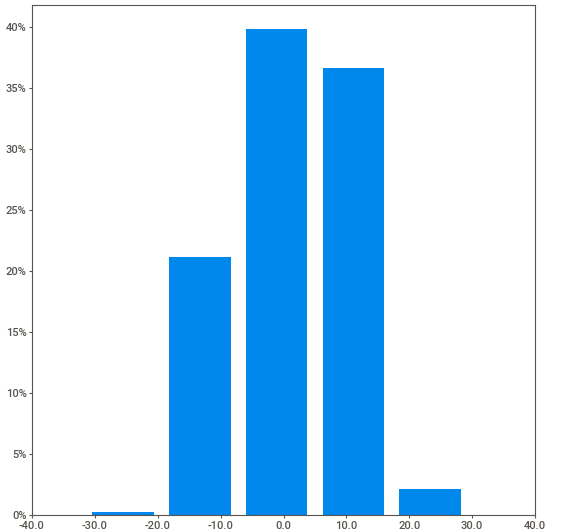
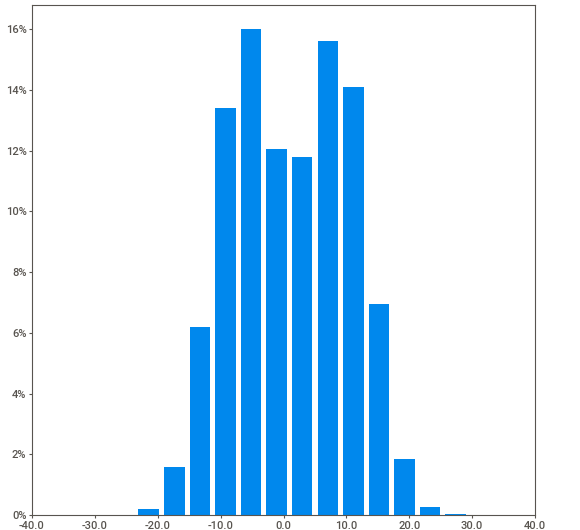
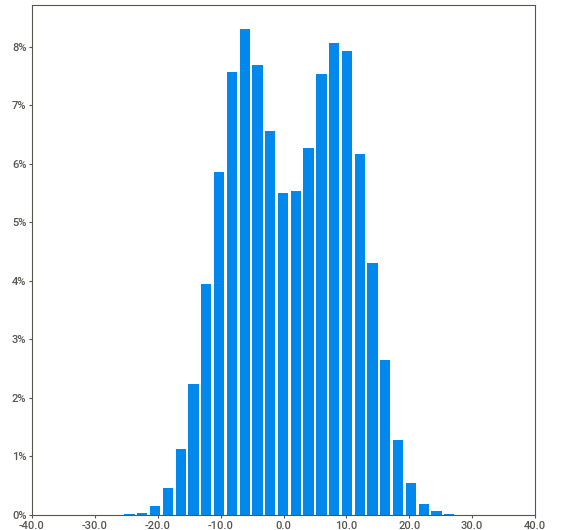
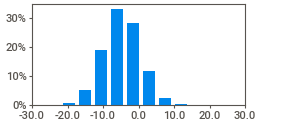
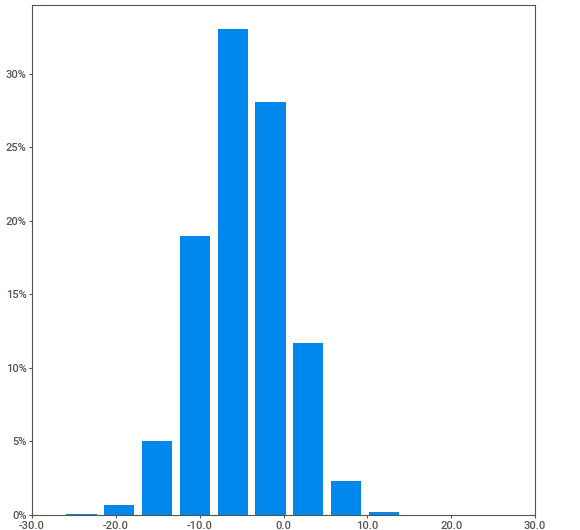
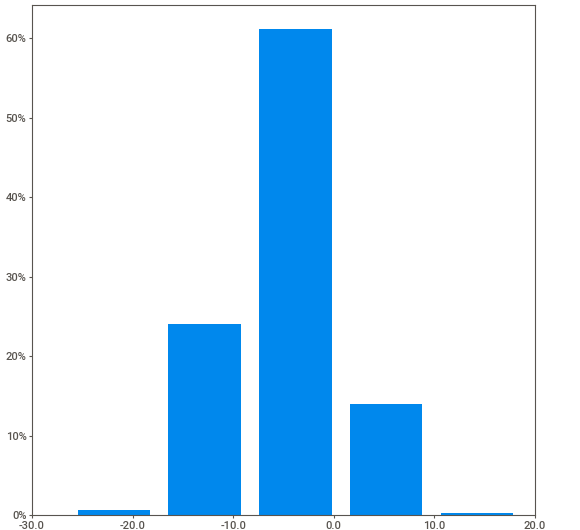
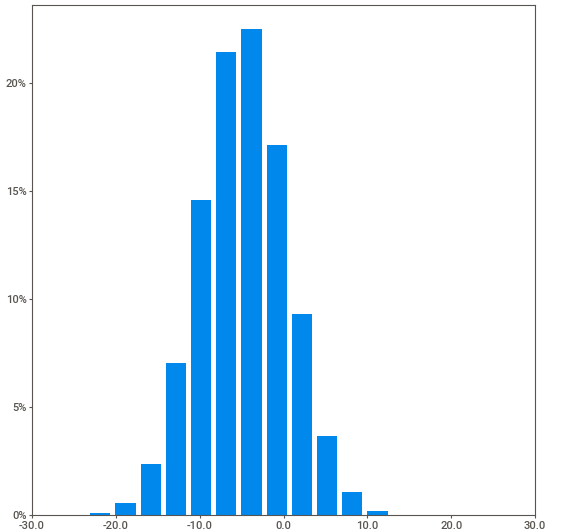
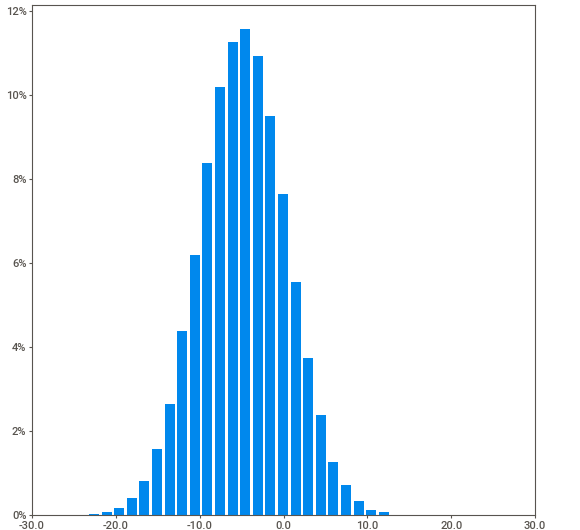
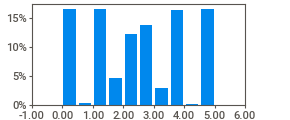
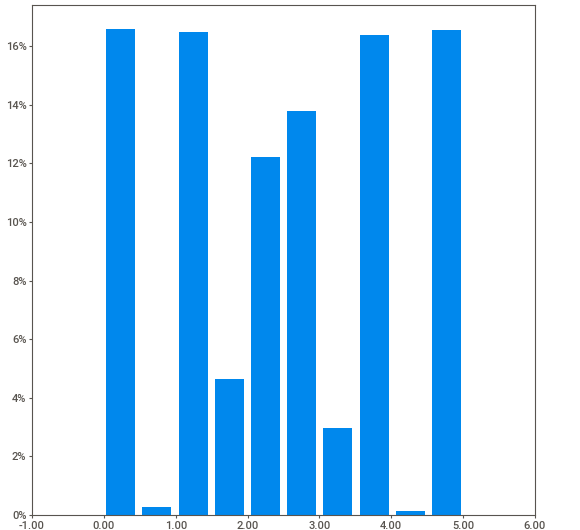
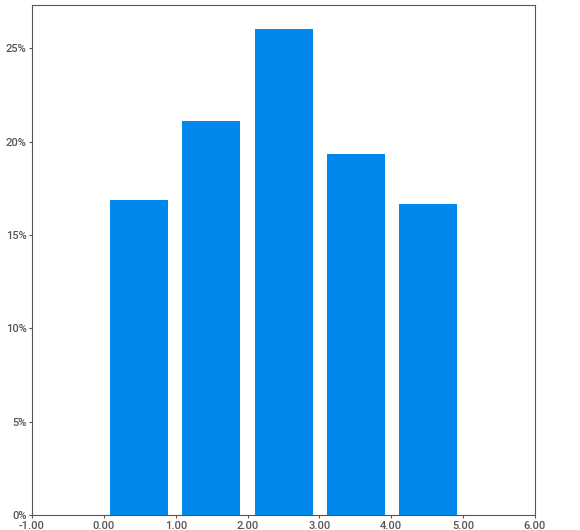
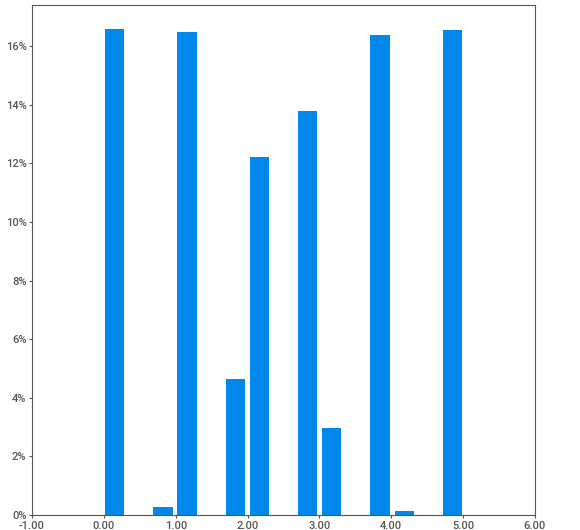
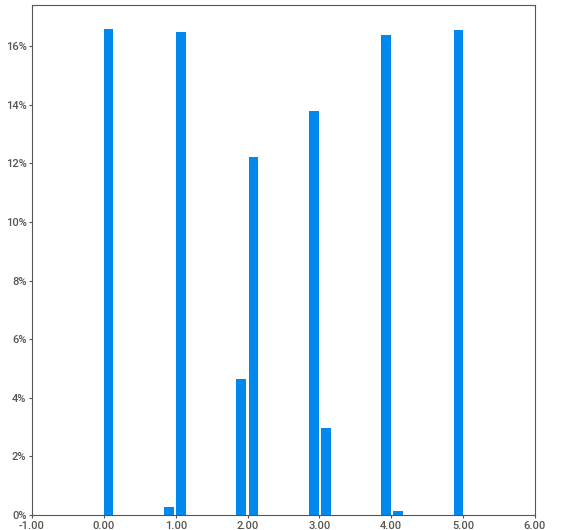
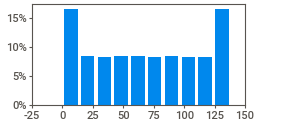
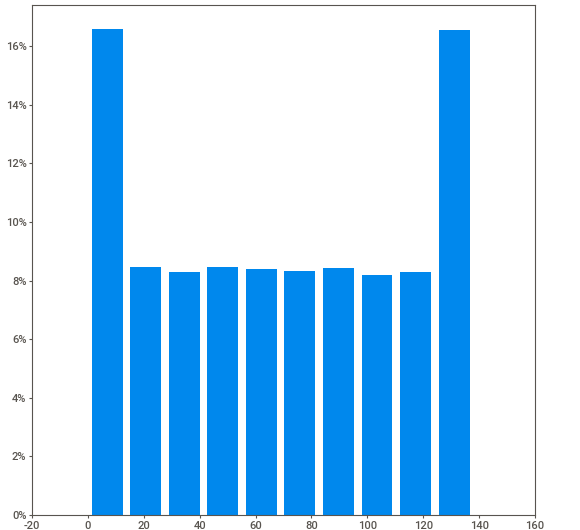
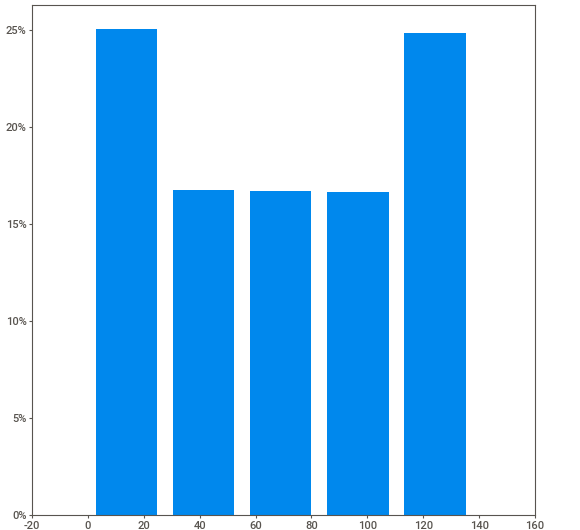
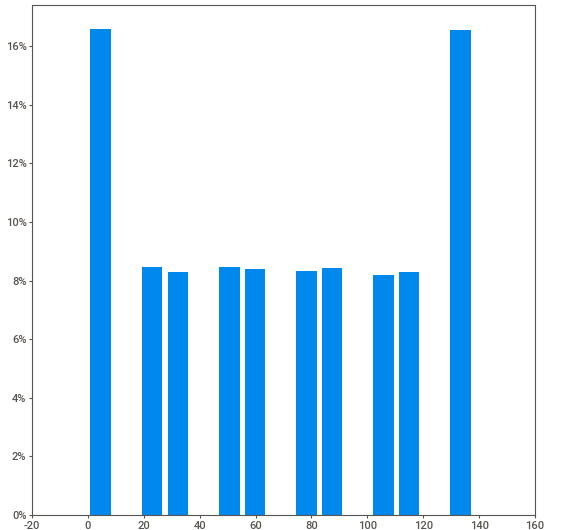
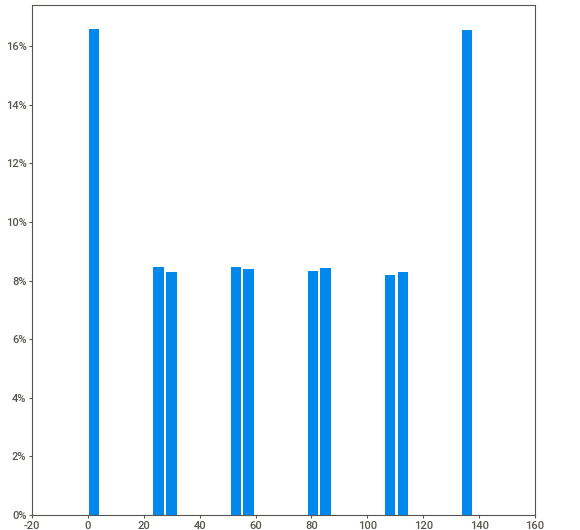
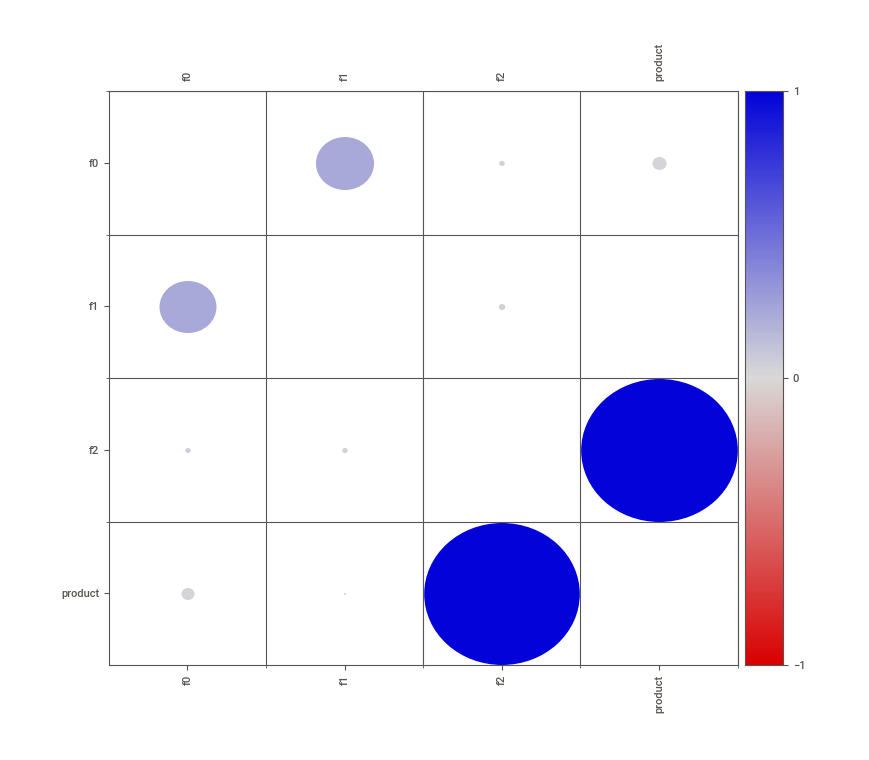
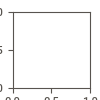

In [7]:
report_reg_2.show_notebook(w='100%', h='full', scale=0.9)


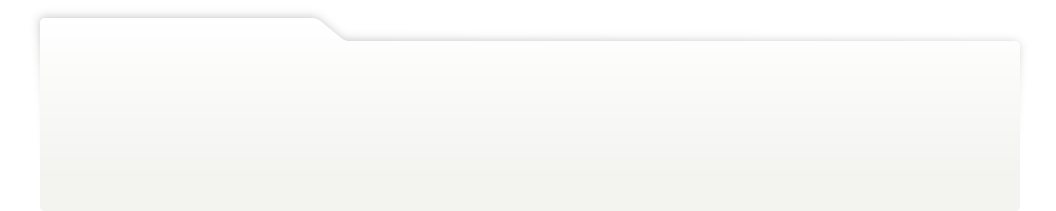
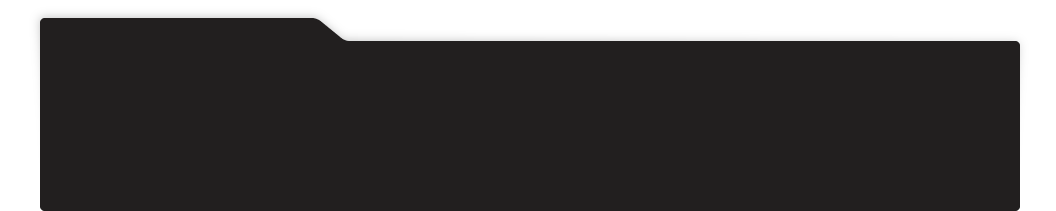
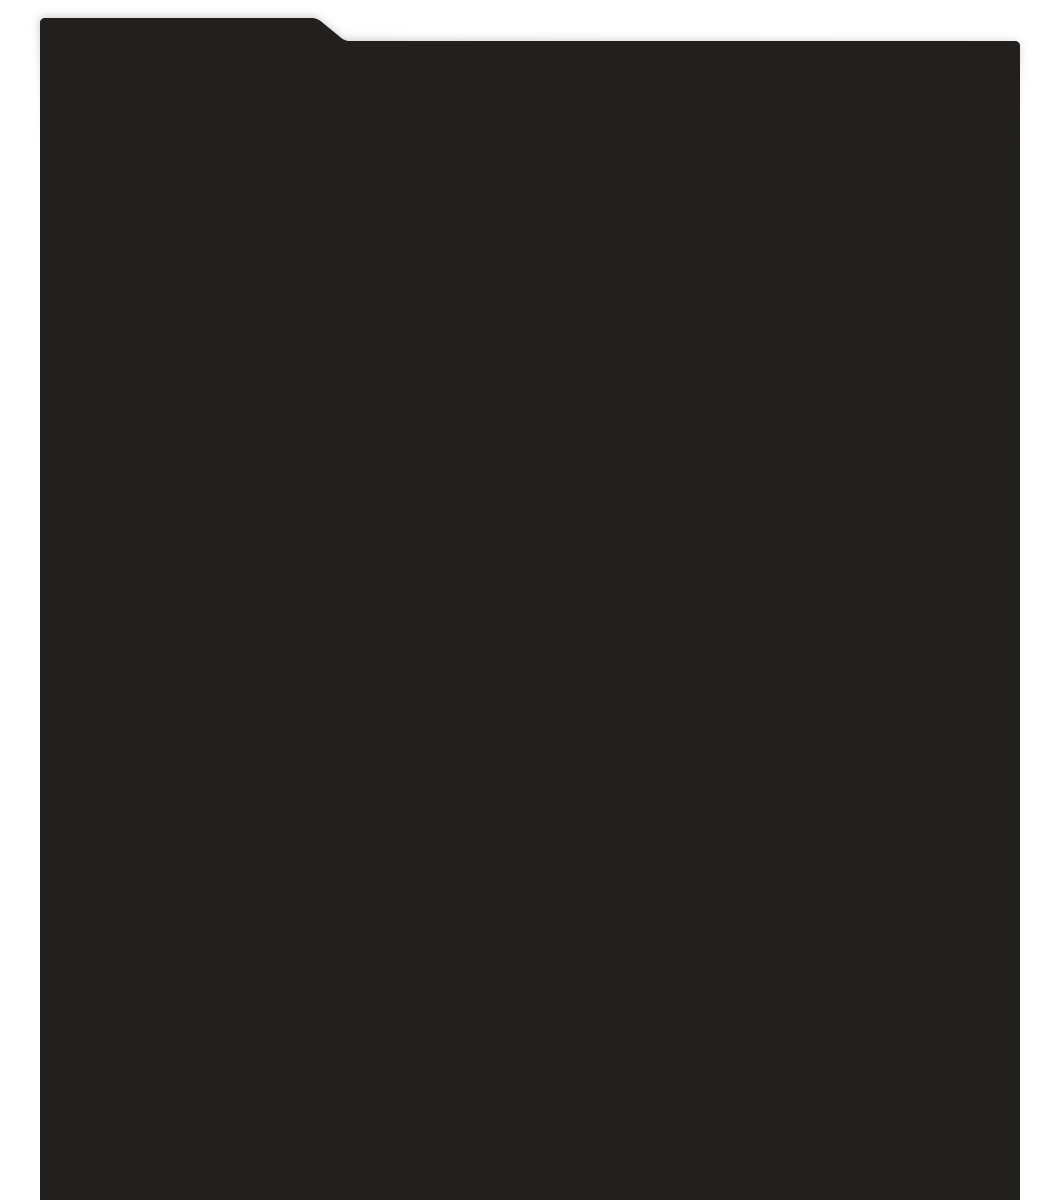
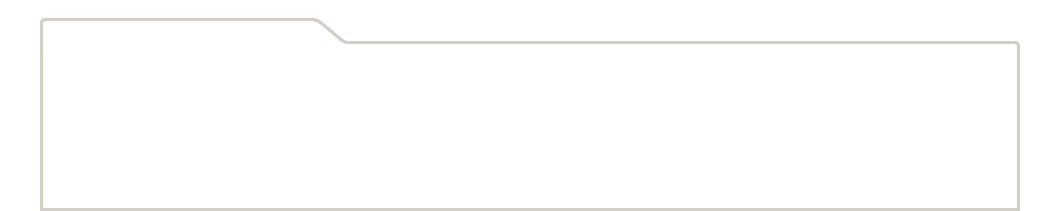
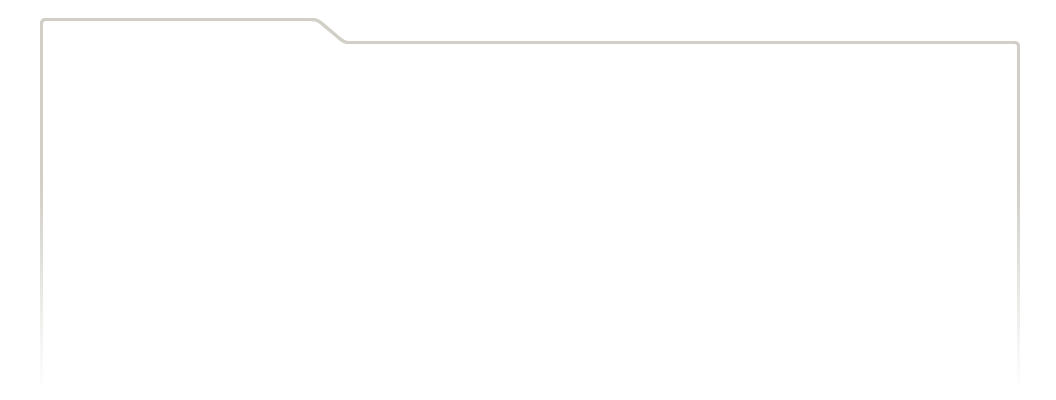
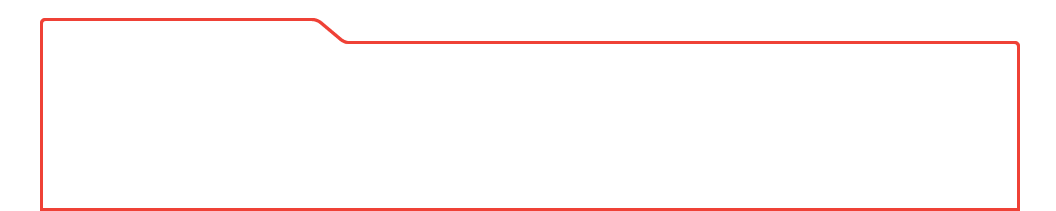
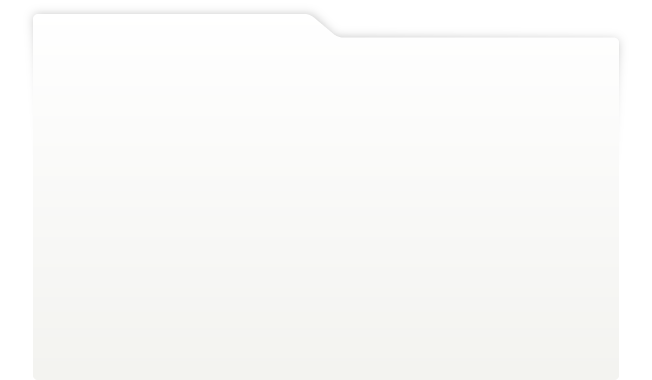
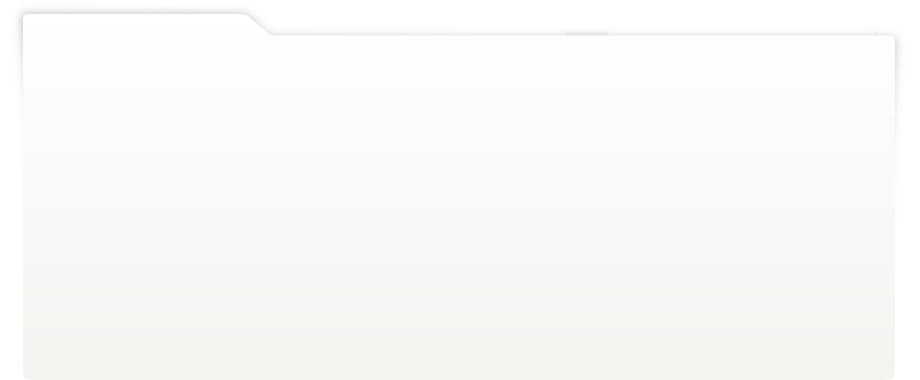
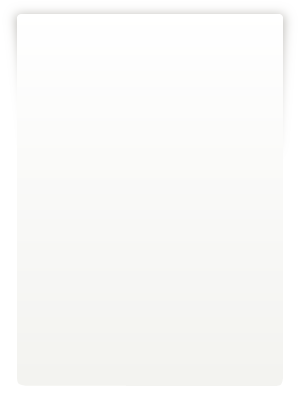
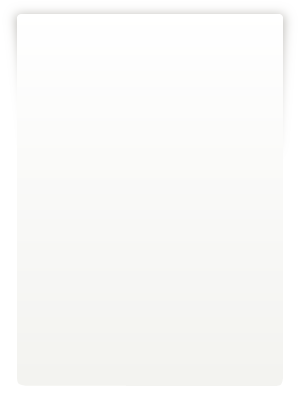
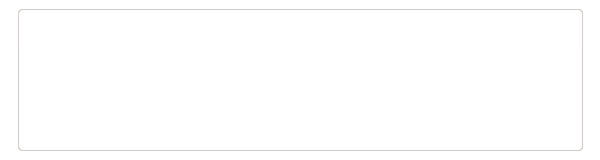
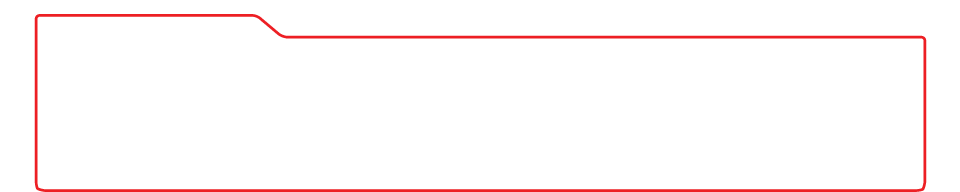
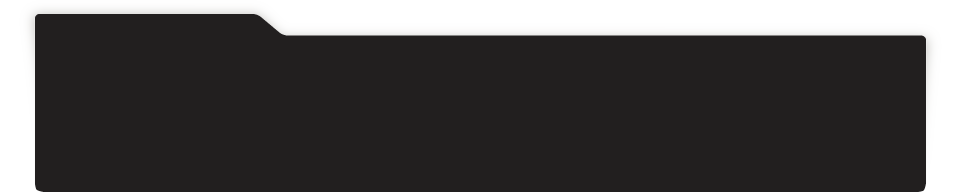
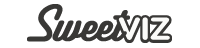
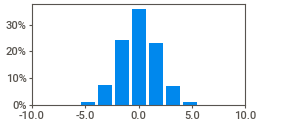
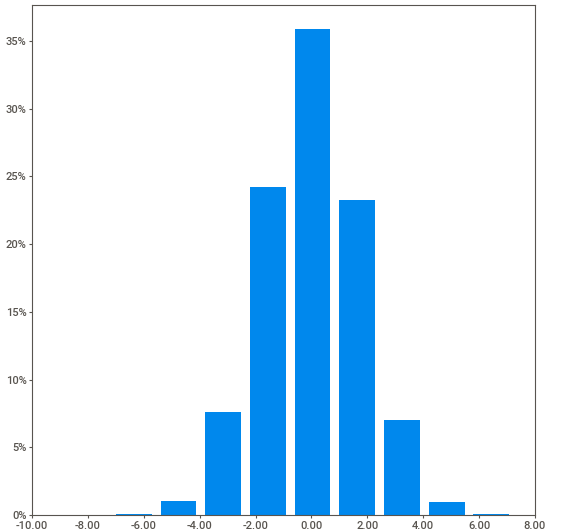
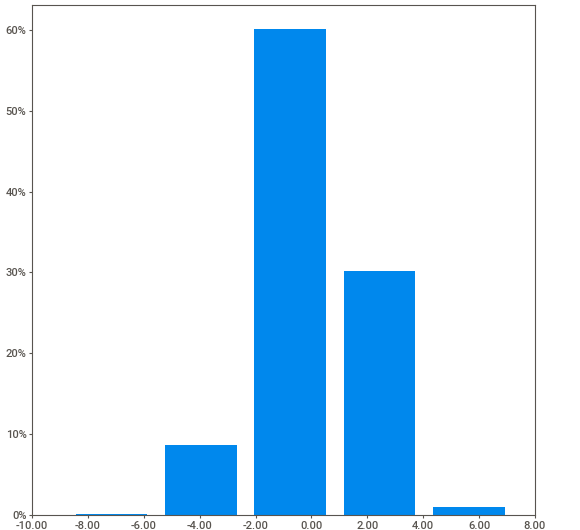
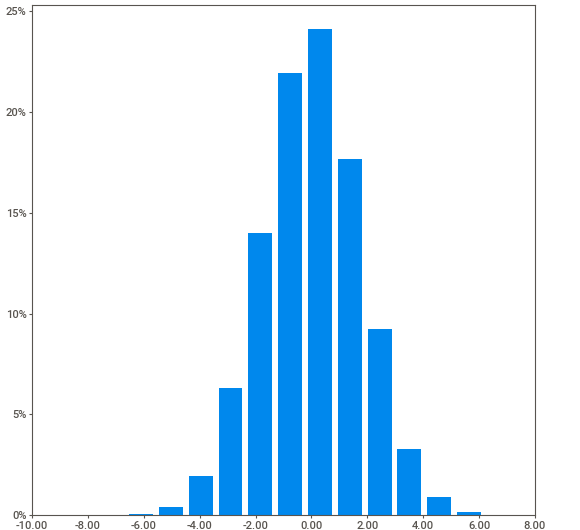
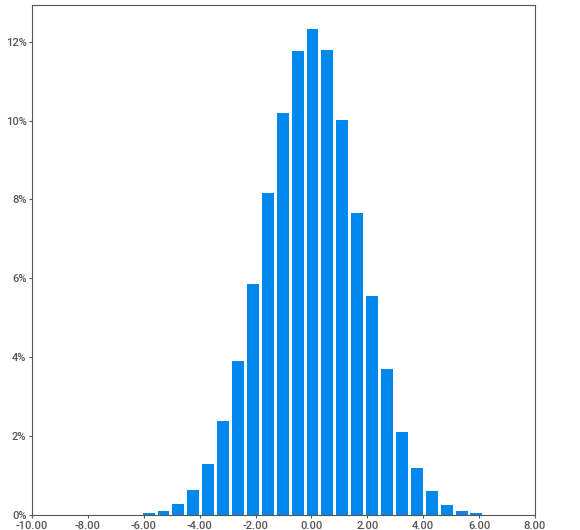
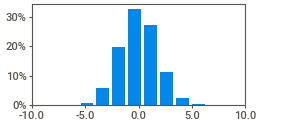
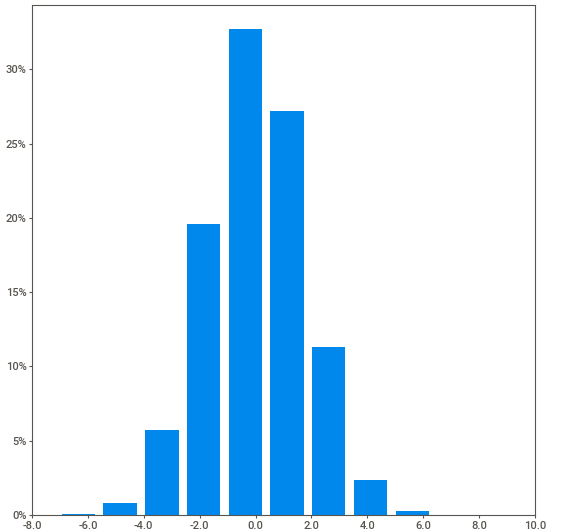
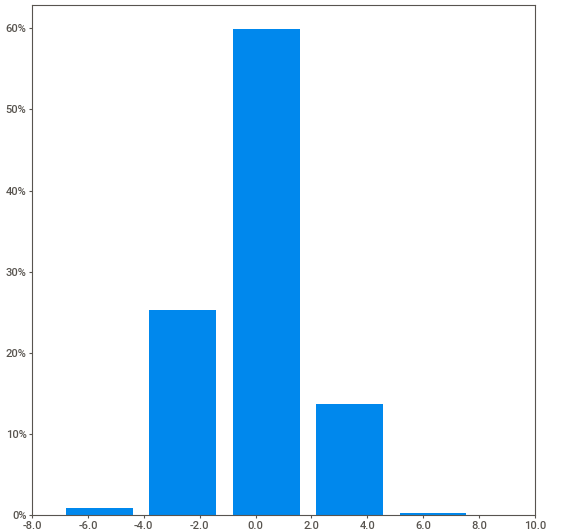
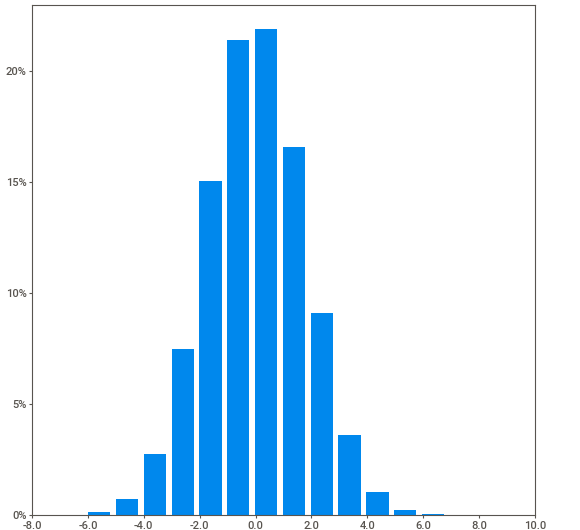
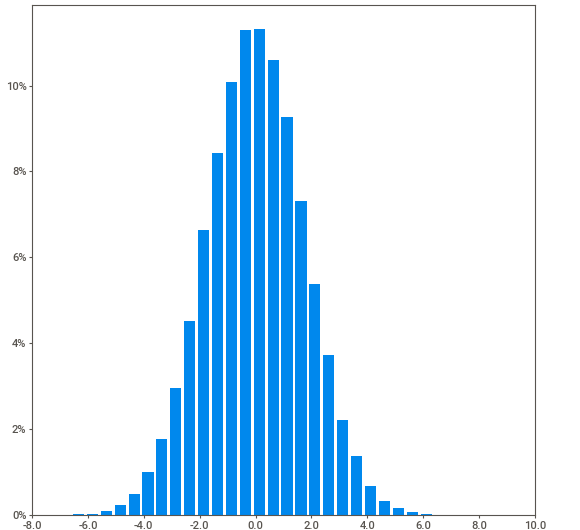
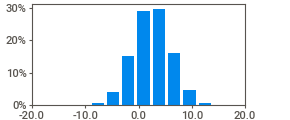
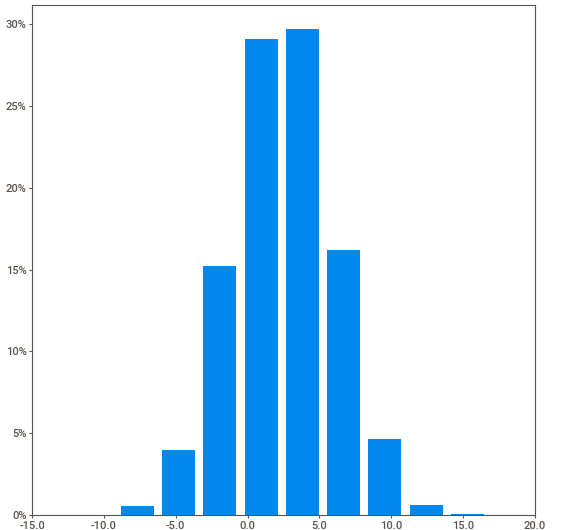
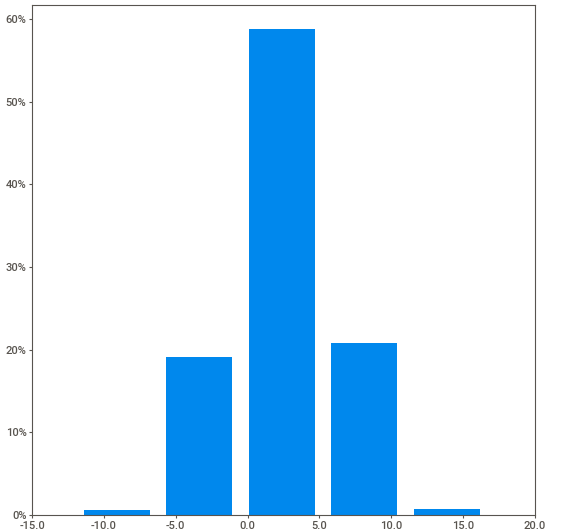
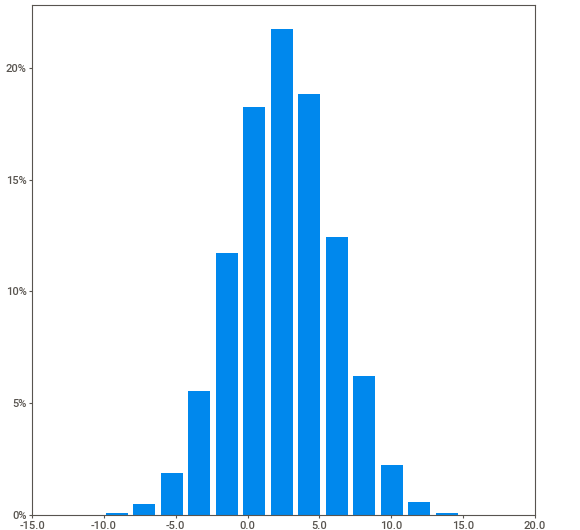
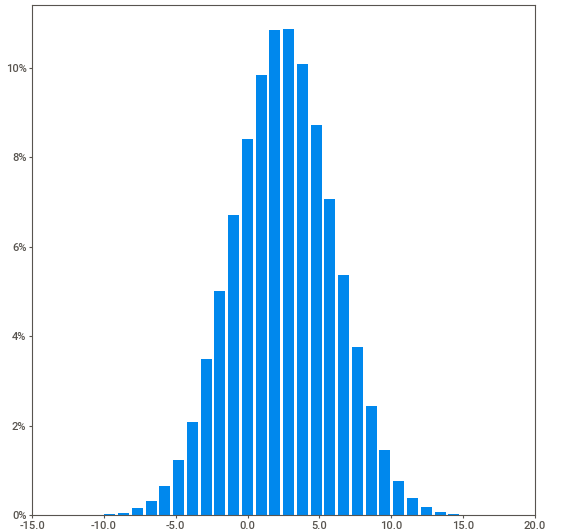
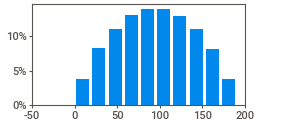
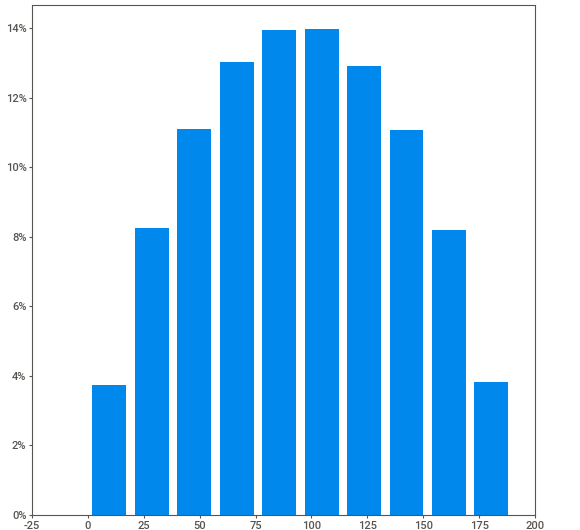
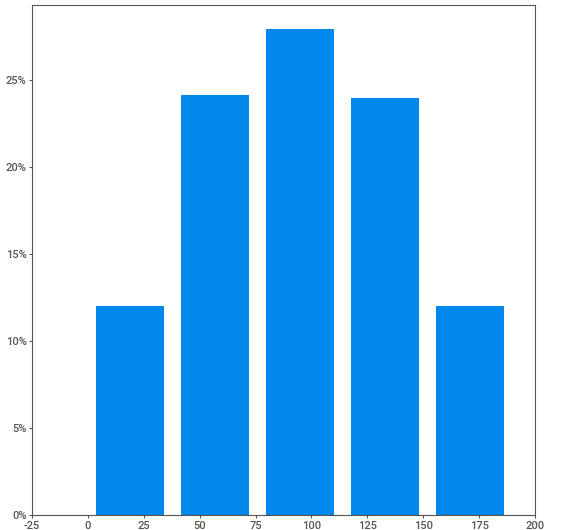
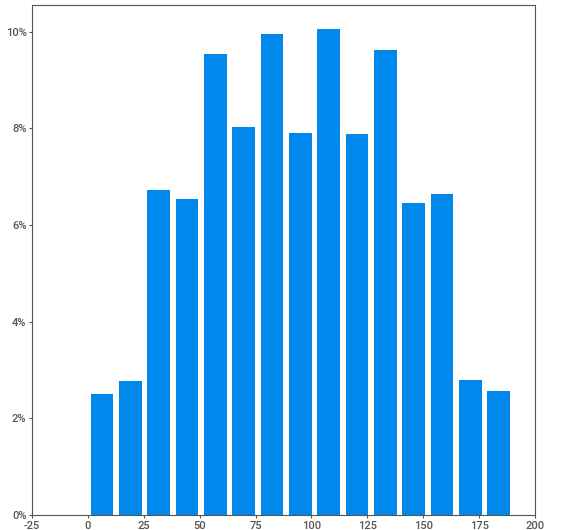
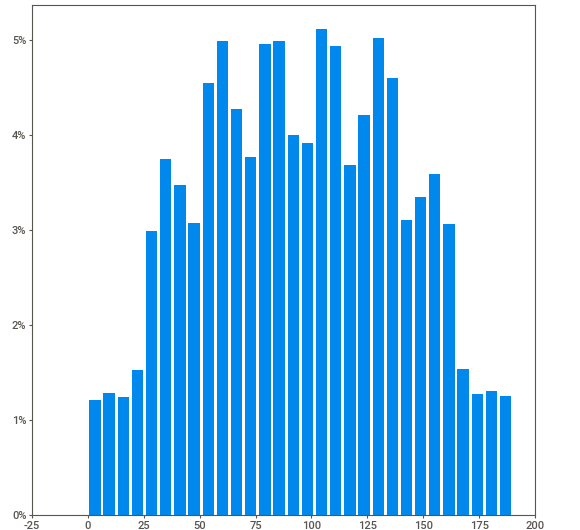
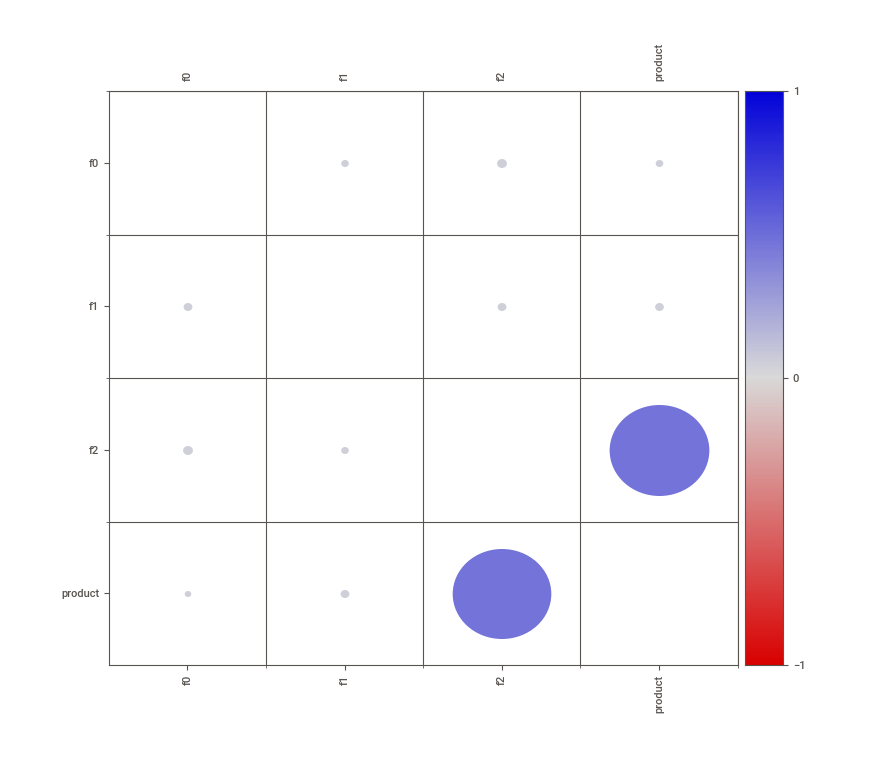
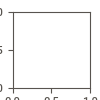

In [8]:
report_reg_3.show_notebook(w='100%', h='full', scale=0.9)

При анализе `sweetviz` было выявлено:

- полных дубликатов нет, но есть дубликаты в столбце `id`
- пустых значений нет
- есть нули в значениях `product` (скважины не принесли нефть)
- пропусков значений нет

Изучим корреляцию между параметрами:

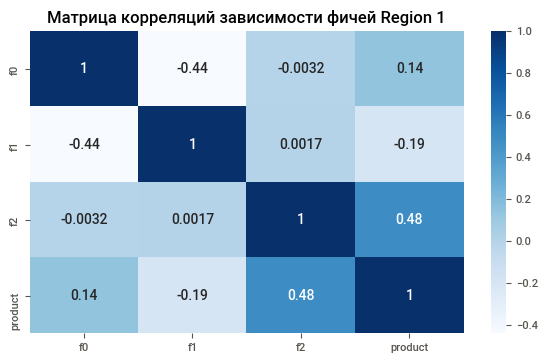

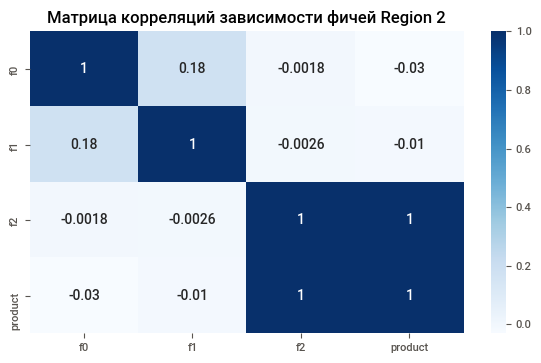

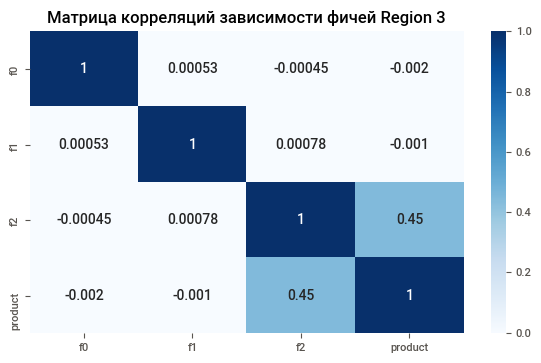

In [9]:
for reg in region_list:
    plt.figure(figsize=(7, 4))
    plt.title(f'Матрица корреляций зависимости фичей {reg}')
    sns.heatmap(region_list[reg].corr(), annot = True, cmap='Blues')
    plt.show()

Во всех регионах значение `f2` коррелирует с количеством продукта. Во втором регионе это же значение прямо коррелирует с количеством продукта. Посмотрим, как это повлияет на будущую модель обучения.

Изучим дубликаты в столбцах `id`:

In [10]:
for reg in region_list:
    duplicated_id = pd.DataFrame(columns=reg_1.columns)
    display(reg)
    for i in region_list[reg][region_list[reg]['id'].duplicated()]['id'].values:
        duplicated_id = pd.concat([duplicated_id] 
                                  + [region_list[reg][region_list[reg]['id'] == i]])
    display(duplicated_id)

'Region 1'

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327


'Region 2'

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


'Region 3'

,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


В регионах дубликаты в параметрах `id` никак не влияют на остальные параметры. Возможно, что одинаковый `id` скважины означает, что использовали иной метод добычи продукта или другую технологию. Или это ошибка при заполнении датасета.

Отбросим столбец `id`, чтобы обучить будущую модель:

In [11]:
reg_1 = reg_1.drop('id', axis=1)
reg_2 = reg_2.drop('id', axis=1)
reg_3 = reg_3.drop('id', axis=1)

## Обучение и проверка модели

Обучим и проверим модель для каждого региона:

1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.
2. Обучим модель и сделаем предсказания на валидационной выборке.
3. Сохраним предсказания и правильные ответы на валидационной выборке.
4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.
5. Проанализируем результаты.

Создаём функцию для подсчета RMSE:

In [12]:
def rmse(target_valid, predictions_valid):
    x = mean_squared_error(target_valid, predictions_valid)**0.5
    return x

Разобьём данные, обучим и сделаем предсказания модели, а так же сохраним результат:

Создаём функцию по подсчету моделей и необходимых значений:

In [13]:
def model_calculate(data):
    # выделяем параметры и таргет
    features = data.drop('product', axis=1)
    target = data['product']

    # делим на валидационную и обучающую
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  test_size=0.25,
                                                                                  random_state=12345)

    # обучаем модель и сохраняем результат
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)

    # считаем RMSE
    rmse_data = rmse(target_valid, predictions)
    return target_valid, predictions, rmse_data

Считаем:

In [14]:
reg_1_tg_valid, predictions_1_valid, rmse_1 = model_calculate(reg_1)
reg_2_tg_valid, predictions_2_valid, rmse_2 = model_calculate(reg_2)
reg_3_tg_valid, predictions_3_valid, rmse_3 = model_calculate(reg_3)

Считаем средний предсказанный запас сырья:

In [15]:
mean_product_1 = predictions_1_valid.mean()
mean_product_2 = predictions_2_valid.mean()
mean_product_3 = predictions_3_valid.mean()

Изучаем результат:

In [16]:
print('Cредний запас предсказанного сырья 1 региона:', round(mean_product_1, 2), 'RMSE:', rmse_1)
print('Cредний запас предсказанного сырья 2 региона:', round(mean_product_2, 2), 'RMSE:', rmse_2)
print('Cредний запас предсказанного сырья 3 региона:', round(mean_product_3, 2), 'RMSE:', rmse_3)

Cредний запас предсказанного сырья 1 региона: 92.59 RMSE: 37.5794217150813
Cредний запас предсказанного сырья 2 региона: 68.73 RMSE: 0.893099286775617
Cредний запас предсказанного сырья 3 региона: 94.97 RMSE: 40.02970873393434


**Вывод**

Лучший параметр RMSE показывает модель на 2 регионе, что скорее всего связано с большой корреляцией параметра f3 и таргета

## Подготовка к расчёту прибыли

1. Все ключевые значения для расчётов сохраним в отдельных переменных.
2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.
3. Напишем выводы по этапу подготовки расчёта прибыли.

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Создаём необходимые переменные:

In [17]:
number_bores = 500 
bores_needed = 200
budget = 10000000000 / 1000000 # в млн. руб.
barrel_price = 450000 / 1000000 # в млн. руб.
risk = 2.5

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

Выведем на экран среднее значение и проанализируем результат:

In [18]:
product_needed = budget / bores_needed / barrel_price

print(f'Необходимый средний объём одной скважины, чтобы она была не убыточна: {product_needed}')
print('')
for reg in region_list:
    x = region_list[reg]['product'].mean()
    if x > product_needed:
        print(f'Средний объём сырья в {reg} не убыточный: {round(x, 3)}')
    else: 
        print(f'Средний объём сырья в {reg} убыточен: {round(x, 3)}')

Необходимый средний объём одной скважины, чтобы она была не убыточна: 111.11111111111111

Средний объём сырья в Region 1 убыточен: 92.5
Средний объём сырья в Region 2 убыточен: 68.825
Средний объём сырья в Region 3 убыточен: 95.0


**Вывод**

Все регионы в среднем указывают, что они убыточны.

## Расчёт прибыли и рисков 

Напишием функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

1. Выберем скважины с максимальными значениями предсказаний.
2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитаем прибыль для полученного объёма сырья.

In [19]:
# преобразуем результаты предсказаний в Pandas Series

predictions_1_valid = pd.Series(predictions_1_valid)
predictions_2_valid = pd.Series(predictions_2_valid)
predictions_3_valid = pd.Series(predictions_3_valid)

In [20]:
# создаём функцию для подсчета прибыли

def revenue_profit(target, bores, count, budget):
    bores_sorted = bores.sort_values(ascending=False) # сортируем по предсказанию
    selected = target[bores_sorted.index][:count] # выбираем лучшие но по фактическим индексам
    revenue = barrel_price * selected.sum() # считаем заработок с выбранных скважин
    profit = revenue - budget # считаем прибыль
    return profit

Посчитаем риски и прибыль для каждого региона:

1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
2. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
3. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.

Создаём функцию для подсчета результатов:

In [21]:
def check_region(target, predictions):
    # создаём список
    values = []

    # применяем Bootstrap
    state = np.random.RandomState(12345)
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=number_bores, replace=True, random_state=state)
        pred_subsample = predictions[target_subsample.index]
        value = revenue_profit(target_subsample, pred_subsample, bores_needed, budget)
        values.append(value)

    # считаем количество убытков
    values = pd.Series(values)
    risk = (values < 0).mean()

    # считаем доверительный интервал
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    # выводим результат
    print('Средняя прибыль в 3 регионе:', round(values.mean(), 2), 'млн. руб')
    print(f'95% доверительный интервал: ({lower}, {upper})')
    print('Риск убытков: {:.1%}'.format((values < 0).mean()))

    # сравниваем с необходимым риском
    if (risk * 100) <= 2.5:
          print('Риск убытков меньше необходимого значения. Регион можно оставить.')
    else:
          print('Риск убытков больше необходимого значения.')      

In [22]:
check_region(reg_1_tg_valid, predictions_1_valid)

Средняя прибыль в 3 регионе: 425.94 млн. руб
95% доверительный интервал: (-102.09009483793592, 947.976353358369)
Риск убытков: 6.0%
Риск убытков больше необходимого значения.


In [23]:
check_region(reg_2_tg_valid, predictions_2_valid)

Средняя прибыль в 3 регионе: 515.22 млн. руб
95% доверительный интервал: (68.87322537050254, 931.547591257049)
Риск убытков: 1.0%
Риск убытков меньше необходимого значения. Регион можно оставить.


In [24]:
check_region(reg_3_tg_valid, predictions_3_valid)

Средняя прибыль в 3 регионе: 435.01 млн. руб
95% доверительный интервал: (-128.88054732978893, 969.7069541802657)
Риск убытков: 6.4%
Риск убытков больше необходимого значения.


**Вывод**

По двум регионам (1 и 3 регион) средняя прибыль меньше, чем у второго региона, а также вероятность убытков выше. Их не стоит рассматривать.

Для дальнейшей разработки нефтяных скважин стоит рассматривать второй регион, так как риск убытков ниже и средняя прибыль выше, чем у остальных регионов.